In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,Dropout,MaxPooling2D,Flatten,Dense,BatchNormalization
from tensorflow.keras import regularizers
import keras
import shutil
import os
from keras_vggface.vggface import VGGFace
from IPython.display import clear_output
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


In [2]:
import tensorflow
print(tensorflow.__version__)


2.9.1


In [3]:
x = []
y = []
datadir = r'Brain Tumor MRI Images 17 Classes'
classes = os.listdir(datadir)
Categories = []
for file_label in os.listdir(datadir):
    Categories.append(file_label)
    for file_name in os.listdir(datadir+'/'+file_label):
        x.append(datadir+'/'+file_label+'/'+file_name)
        y.append(file_label)

dataset=pd.DataFrame({
        'image_path' : x,
        'label' : y
    })

In [4]:
train_df, test_df = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=123, stratify=dataset['label'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123)

In [5]:
print("train_df = ",len(train_df))
print("valid_df = ",len(valid_df))
print("test_df = ",len(test_df))

train_df =  3558
valid_df =  445
test_df =  445


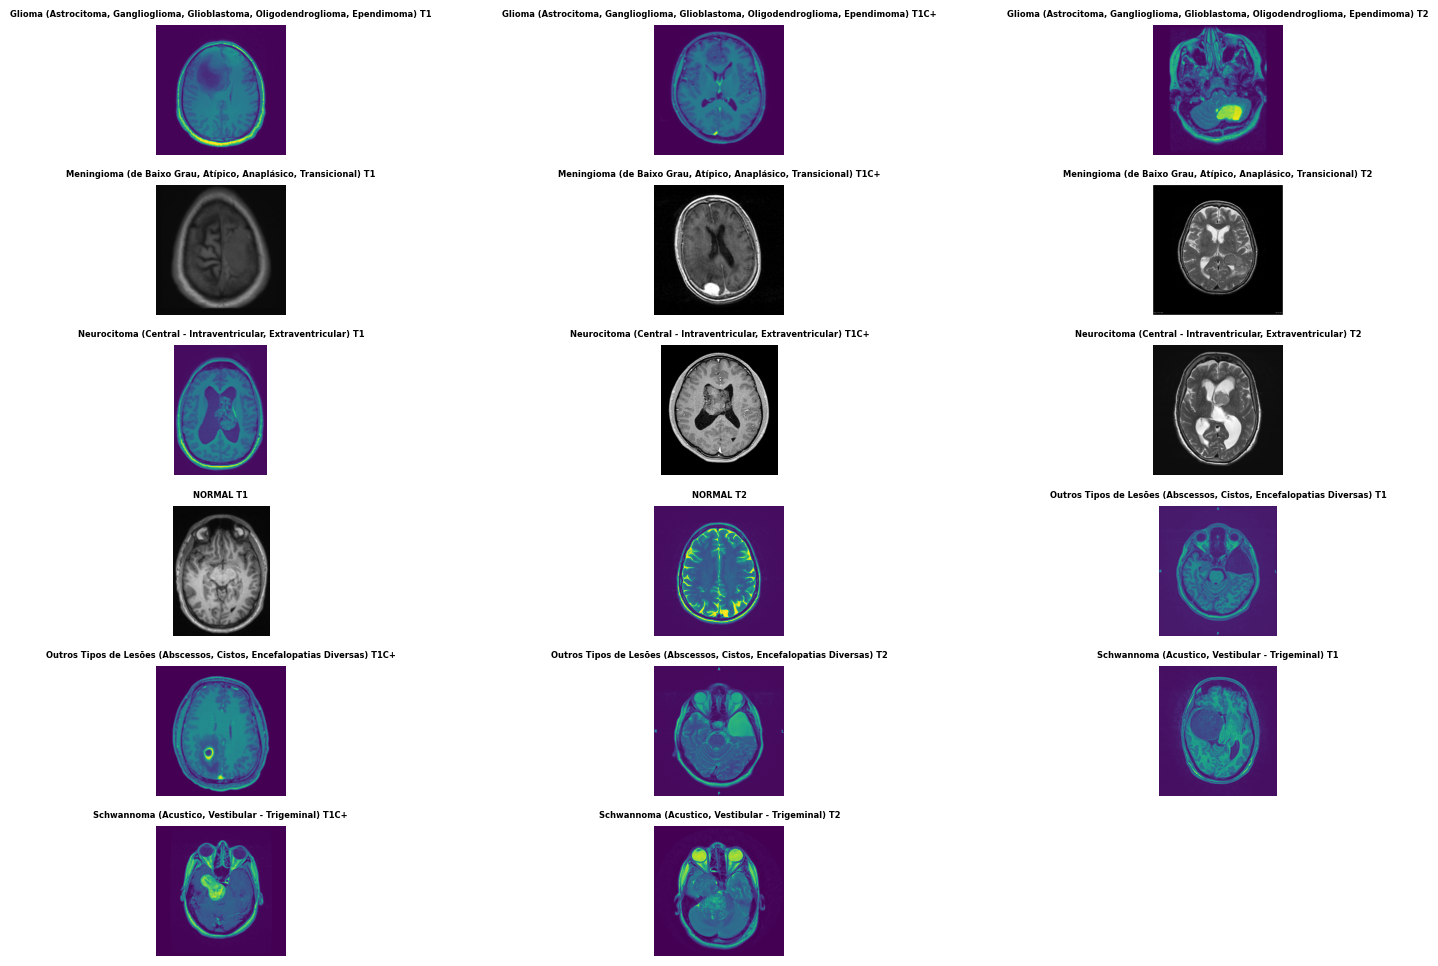

In [6]:
import random
a=0
plt.figure(figsize=(15,10))
for i in classes:
    ax = plt.subplot(6,3, a+1)
    plt.tight_layout()
    path=os.path.join(datadir+'/'+i)
    img = plt.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(img)
    plt.title(i,fontsize=6,weight='bold')
    plt.axis('off')
    a+=1
plt.savefig('models/17class/sample_17.png',bbox_inches='tight')
plt.show()


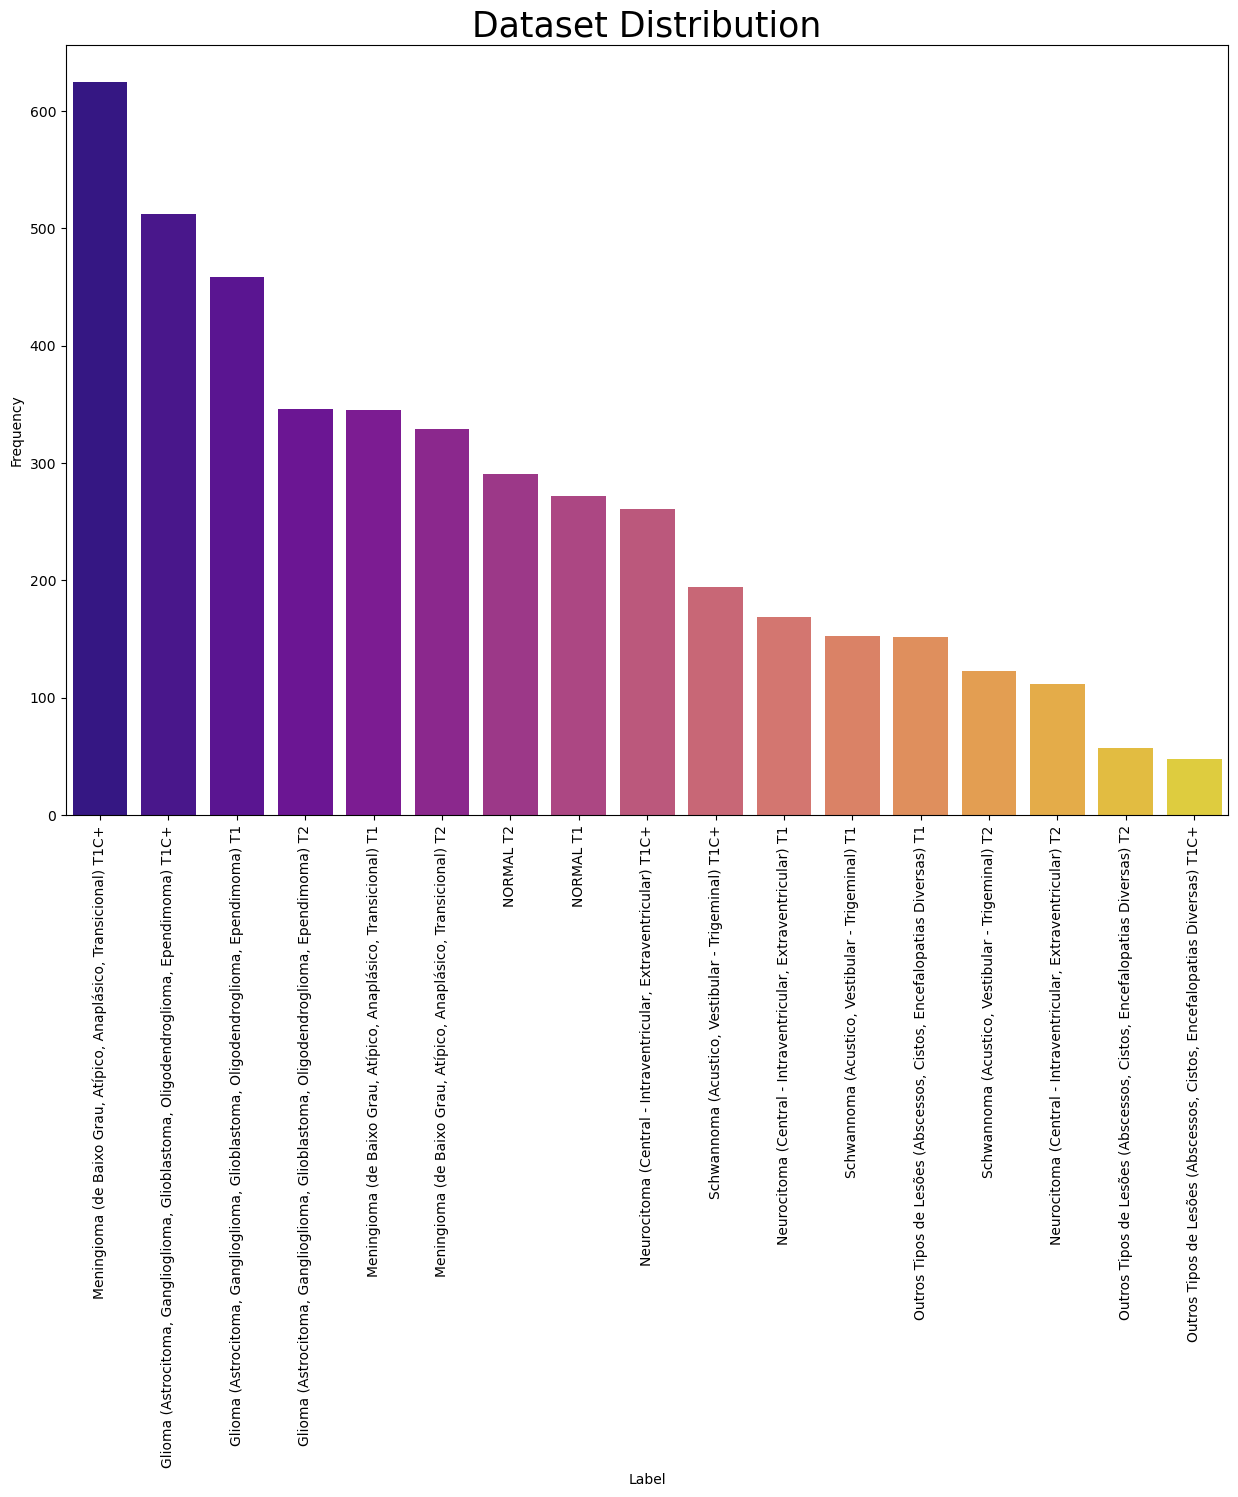

In [7]:
x=dataset.label
plt.figure(figsize=(15,10))
plt.title('Dataset Distribution', fontsize=25)
sns.countplot(x = x, palette='plasma', order = x.value_counts().index)
plt.xticks(rotation = 90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Label', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('models/17class/distribution_17.png',bbox_inches='tight')
plt.show()

In [6]:
train_datagen = ImageDataGenerator(horizontal_flip= True)

test_datagen = ImageDataGenerator()

In [7]:
training_set = train_datagen.flow_from_dataframe( train_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 32)

Found 3533 validated image filenames belonging to 17 classes.


c:\Users\Ruby\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 25 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [8]:
vald_set = test_datagen.flow_from_dataframe( valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 32)

Found 441 validated image filenames belonging to 17 classes.


c:\Users\Ruby\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [9]:
test_set = test_datagen.flow_from_dataframe( test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'label', 
                                      target_size= (224,224), 
                                      class_mode= 'categorical',
                                      color_mode= "rgb", 
                                      shuffle= False, 
                                      batch_size= 32)

Found 441 validated image filenames belonging to 17 classes.


c:\Users\Ruby\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [20]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [11]:
base_model = keras.models.load_model('44class_96.5.h5')
for layer in base_model.layers:
    layer.trainable=False

In [12]:
base_model.pop()
base_model.pop()
base_model.pop()

In [13]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
Total params: 28,521,719
Trainable params: 0
Non-trainable params: 28,521,719
_________________________________________________________________


In [14]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    Dense(17, activation= 'softmax')
])

In [15]:
""" model = Sequential()
model.add(base_model)
model.add(Dense(2, activation="softmax")) """

' model = Sequential()\nmodel.add(base_model)\nmodel.add(Dense(2, activation="softmax")) '

In [16]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              28521719  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 17)                4369      
                                                                 
Total params: 29,058,824
Trainable params: 533,009
Non-trainable params: 28,525,815
______________________________________

In [17]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

checkpoint_name = 'Best-val_accuracy.h5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy', verbose = 1, save_best_only = True,save_weights_only=True, mode ='auto')

checkpoint_name1 = 'Best-val_loss.h5' 
checkpoint1 = ModelCheckpoint(checkpoint_name1, monitor='val_loss', verbose = 1, save_best_only = True,save_weights_only=True, mode ='auto')

In [18]:
res = model.fit(training_set,validation_data = vald_set, epochs=300,shuffle=False,callbacks=[checkpoint,checkpoint1,early_stopping])

Epoch 1/300
111/111 [==============================] - ETA: 0s - loss: 7.6250 - accuracy: 0.8712
Epoch 1: val_accuracy improved from -inf to 0.95918, saving model to Best-val_accuracy.h5

Epoch 1: val_loss improved from inf to 6.18811, saving model to Best-val_loss.h5
111/111 [==============================] - 46s 300ms/step - loss: 7.6250 - accuracy: 0.8712 - val_loss: 6.1881 - val_accuracy: 0.9592
Epoch 2/300
111/111 [==============================] - ETA: 0s - loss: 5.4988 - accuracy: 0.9380
Epoch 2: val_accuracy improved from 0.95918 to 0.96599, saving model to Best-val_accuracy.h5

Epoch 2: val_loss improved from 6.18811 to 4.64244, saving model to Best-val_loss.h5
111/111 [==============================] - 28s 255ms/step - loss: 5.4988 - accuracy: 0.9380 - val_loss: 4.6424 - val_accuracy: 0.9660
Epoch 3/300
111/111 [==============================] - ETA: 0s - loss: 4.1454 - accuracy: 0.9558
Epoch 3: val_accuracy did not improve from 0.96599

Epoch 3: val_loss improved from 4.6424

In [22]:
#model.load_weights('Best-val_accuracy.h5')
model = keras.models.load_model('17class_98.1.h5')

In [23]:
train_score = model.evaluate(training_set)
valid_score = model.evaluate(vald_set)
test_score = model.evaluate(test_set)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 [==============================] - 5s 334ms/step - loss: 0.2504 - accuracy: 0.9819
Train Loss:  0.20313376188278198
Train Accuracy:  0.9980186820030212
--------------------
Validation Loss:  0.23657742142677307
Validation Accuracy:  0.9863945841789246
--------------------
Test Loss:  0.2503776252269745
Test Accuracy:  0.9818593859672546


In [ ]:
#model.save('17class_98.1.h5')

In [25]:
y_pred = model.predict(test_set)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_set.classes

14/14 [==============================] - 6s 221ms/step


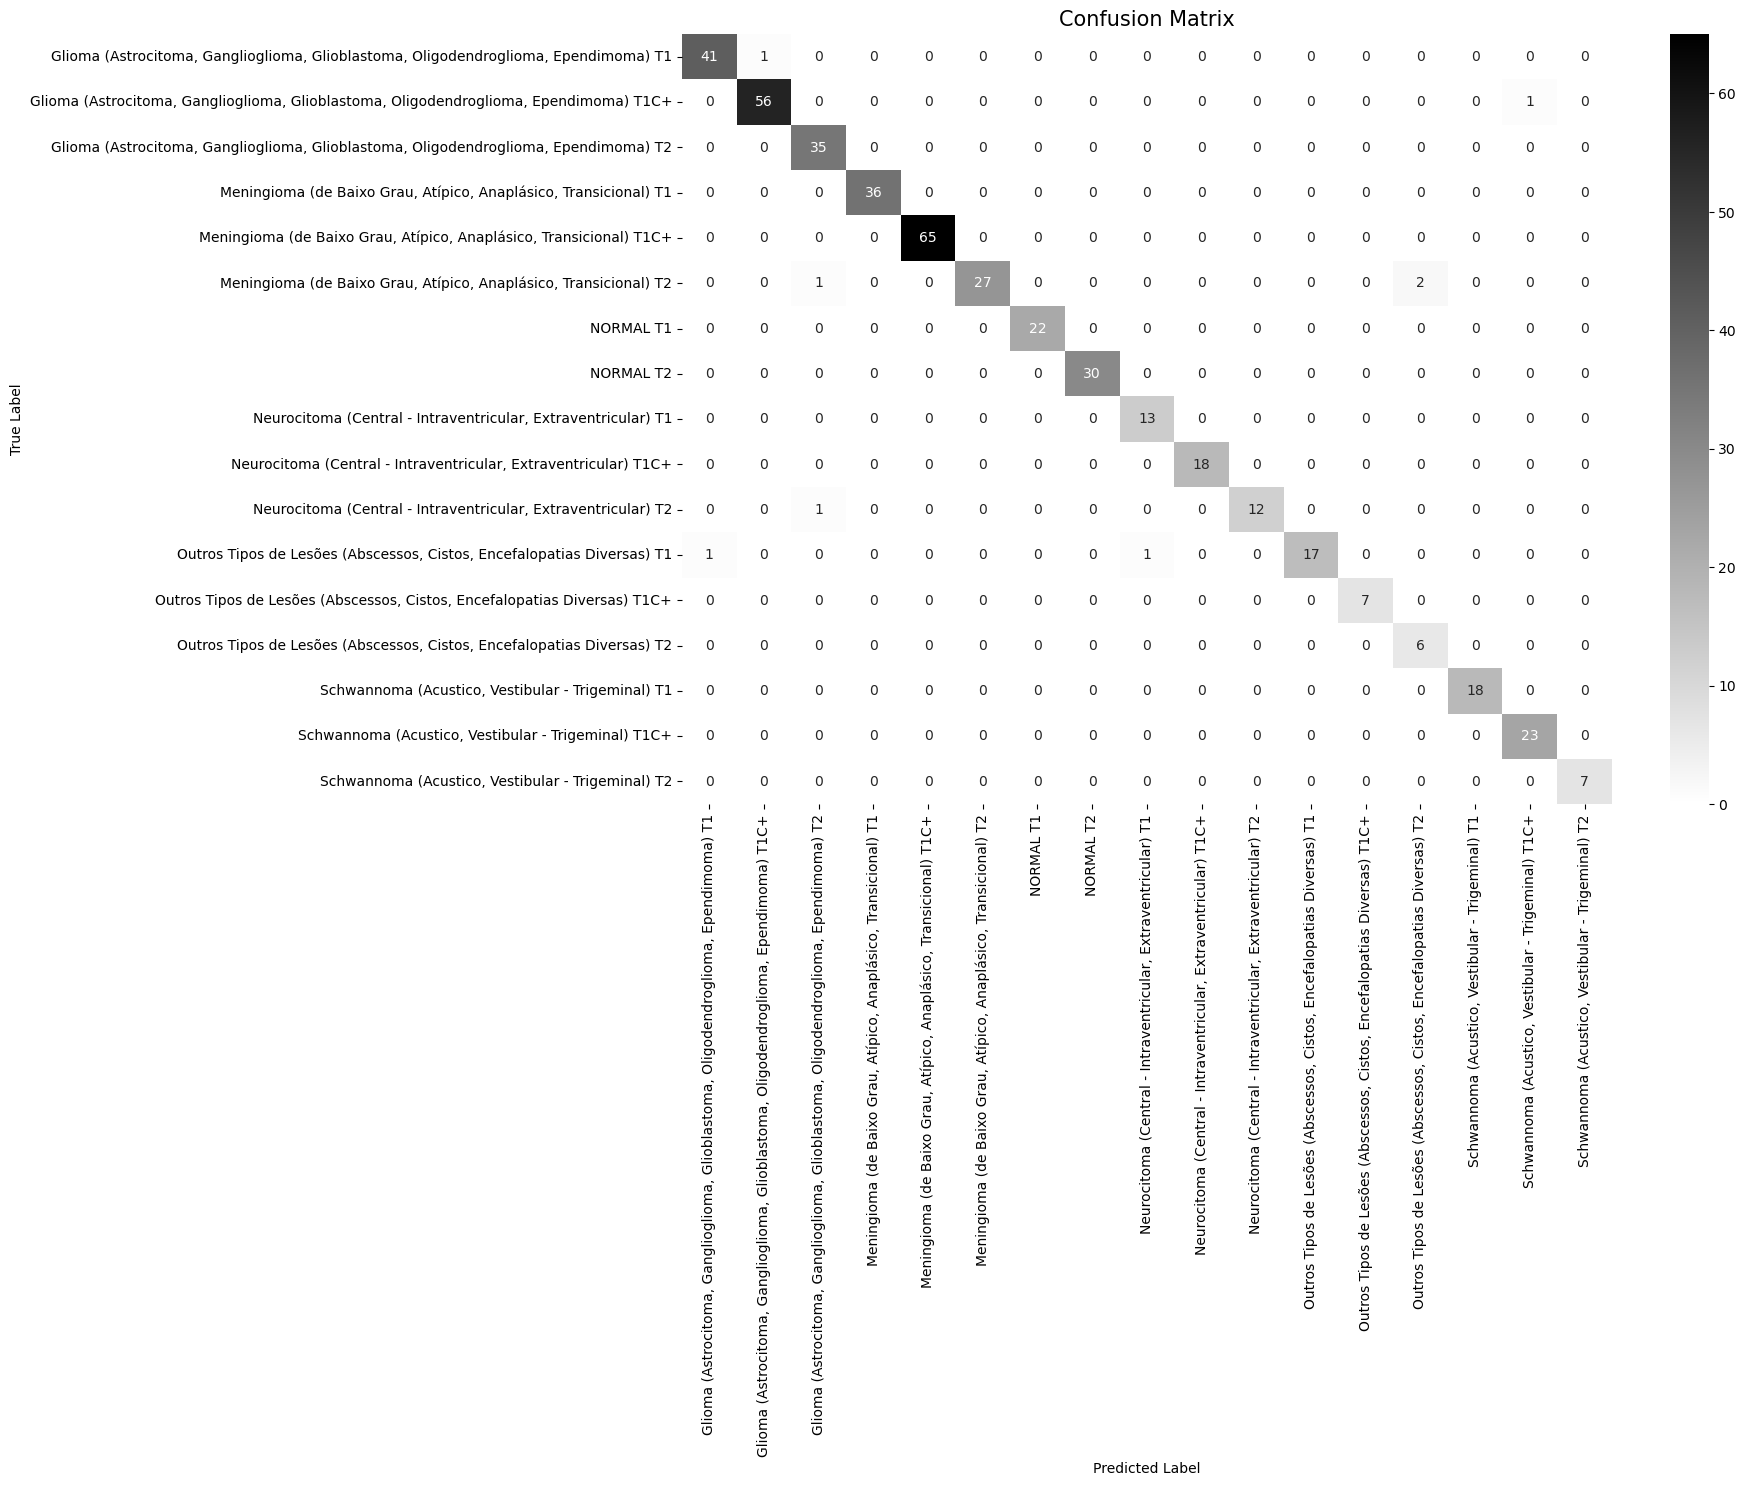

In [26]:
class_names = list(test_set.class_indices.keys())
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(15,10))
sns.heatmap(confusion_mtx, annot=True, xticklabels=class_names, yticklabels=class_names,cmap='binary')
plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.savefig('models/17class/confusion_matrix_17.png',bbox_inches='tight')
plt.show()

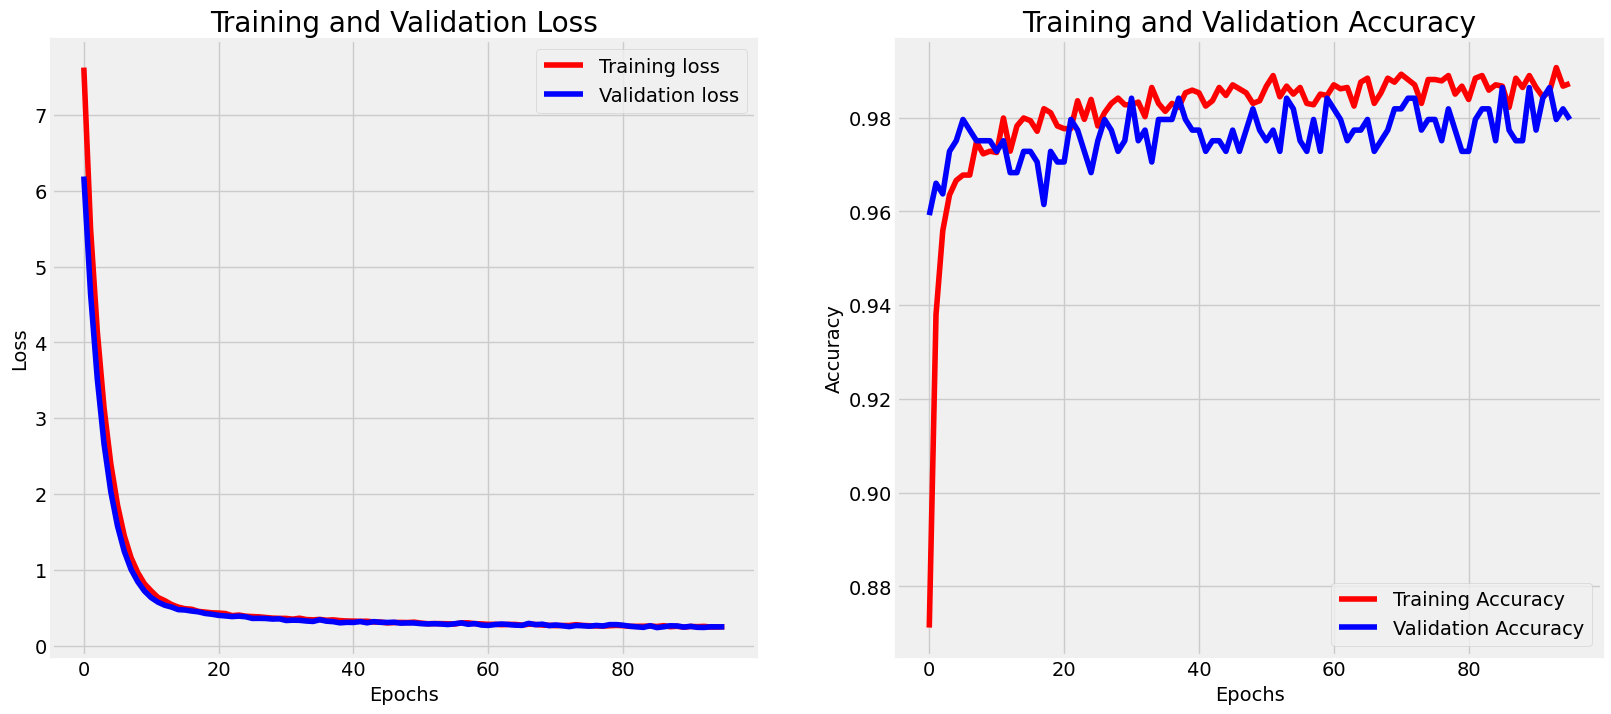

In [19]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(res.history['loss'], 'r', label= 'Training loss')
plt.plot(res.history['val_loss'], 'b', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(res.history['accuracy'], 'r', label= 'Training Accuracy')
plt.plot(res.history['val_accuracy'], 'b', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.savefig('EfficientNetB5_2calss.png')
plt.show()

In [11]:
#list(test_set.class_indices.keys())